In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

train_series = pd.read_parquet('train_series.parquet', engine = 'pyarrow')

series_id = train_series['series_id'].unique() #setting apart the unique series_ids, get a sense for how many patients the true dataset covers.

#downsampling

every_6th_ID = series_id[0::10] #swapped to 10 for prediction (Memory issues)
every_6th_data = train_series[train_series['series_id'].isin(every_6th_ID)]

train_events = pd.read_csv('train_events.csv')

lst_IDs = every_6th_data['series_id'].unique()

filtered_events = train_events[train_events['series_id'].isin(lst_IDs)]

#finally...
merged_data = pd.merge(every_6th_data, filtered_events, on=['timestamp', 'series_id'], how='left')

#print(lst_IDs)

In [2]:
test_series = pd.read_parquet('test_series.parquet', engine = 'pyarrow')

In [3]:
class CreateFeatureFrames: #A class to separate out the feature frames, creating one for my .parquet and one for my .csv
    
    def calculate_accel_stats(accel_data, window_size=10):
        
        #accel_data = merged_data[merged_data['series_id'] == series_ID].copy()
    
        #mean, variance, and max for 'anglez' and 'enmo'
        accel_data['anglez_mean'] = accel_data['anglez'].rolling(window=window_size).mean()
        accel_data['anglez_var'] = accel_data['anglez'].rolling(window=window_size).var()
        accel_data['anglez_max'] = accel_data['anglez'].rolling(window=window_size).max()
    
        accel_data['enmo_mean'] = accel_data['enmo'].rolling(window=window_size).mean()
        accel_data['enmo_var'] = accel_data['enmo'].rolling(window=window_size).var()
        accel_data['enmo_max'] = accel_data['enmo'].rolling(window=window_size).max()
    
        # dataframe to store the new stats
        full_on_stats = pd.DataFrame({
            'series_id': accel_data['series_id'],
            'timestamp': accel_data['timestamp'],
            'anglez_mean': accel_data['anglez_mean'],
            'anglez_var': accel_data['anglez_var'],
            'anglez_max': accel_data['anglez_max'],
            'enmo_mean': accel_data['enmo_mean'],
            'enmo_var': accel_data['enmo_var'],
            'enmo_max': accel_data['enmo_max']
        })
    
        # drop NaN values
        full_on_stats.dropna(inplace=True)
    
        return full_on_stats

    def pull_labeled_stats(filtered_events, full_on_stats):
        
        #filtered_events1 = filtered_events[filtered_events['series_id'] == series_ID].copy()
        aggie_stats = pd.merge(full_on_stats, filtered_events)
        
        return aggie_stats


In [4]:
stats = CreateFeatureFrames.calculate_accel_stats(merged_data)
labeled_stats = CreateFeatureFrames.pull_labeled_stats(filtered_events, stats)

#merging dataframes for ease
data = pd.merge(stats, labeled_stats, on=['series_id','timestamp','enmo_var','anglez_var','anglez_mean','anglez_max','enmo_mean','enmo_max'], how='left')

In [5]:
#stats_test = CreateFeatureFrames.calculate_accel_stats(test_series)

In [37]:
#import numpy as np
from sklearn.model_selection import train_test_split

X_train = (data[['anglez_mean','anglez_var','anglez_max','enmo_mean','enmo_var','enmo_max']]) #X_training dataset from frame
y_train = (data['event']) #Y, my "response", is onset/wake
data['event'].fillna(0, inplace=True)
data['event'] = data['event'].map({'onset': 1, 'wakeup': 1}).fillna(data['event']) #for now, just going off of signal. Awake = 0 , not awake = 1

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=None)

#X_test = (stats_test['enmo_var'])

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5), #For my first model, I will attempt to drop some layers to avoid overfitting
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) #That didn't work...

Epoch 1/5
7321/7321 [==============================] - 27s 3ms/step - loss: 0.0873 - accuracy: 0.9968 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 2/5
7321/7321 [==============================] - 24s 3ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 8.3184e-04 - val_accuracy: 0.9999
Epoch 3/5
7321/7321 [==============================] - 24s 3ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 8.2140e-04 - val_accuracy: 0.9999
Epoch 4/5
7321/7321 [==============================] - 24s 3ms/step - loss: 9.5239e-04 - accuracy: 0.9999 - val_loss: 8.0489e-04 - val_accuracy: 0.9999
Epoch 5/5
7321/7321 [==============================] - 24s 3ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 8.0187e-04 - val_accuracy: 0.9999


In [39]:
from sklearn.metrics import roc_curve, auc
def performance_plots(model, X_Train, y_Train, X_Test, y_Test):

    history=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=10, batch_size=2048)
    scores = model.evaluate(X_Test, y_Test)
    
    plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
    plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
    plt.legend()

    plt.show()
    
    print(scores)

Epoch 1/10
5107/5107 [==============================] - 21s 4ms/step - loss: 8.7367e-04 - accuracy: 0.9999 - val_loss: 7.9502e-04 - val_accuracy: 0.9999
Epoch 2/10
5107/5107 [==============================] - 20s 4ms/step - loss: 8.9107e-04 - accuracy: 0.9999 - val_loss: 8.1913e-04 - val_accuracy: 0.9999
Epoch 3/10
5107/5107 [==============================] - 20s 4ms/step - loss: 8.6378e-04 - accuracy: 0.9999 - val_loss: 7.9307e-04 - val_accuracy: 0.9999
Epoch 4/10
5107/5107 [==============================] - 21s 4ms/step - loss: 8.6106e-04 - accuracy: 0.9999 - val_loss: 7.9217e-04 - val_accuracy: 0.9999
Epoch 5/10
5107/5107 [==============================] - 20s 4ms/step - loss: 8.6521e-04 - accuracy: 0.9999 - val_loss: 7.8955e-04 - val_accuracy: 0.9999
Epoch 6/10
5107/5107 [==============================] - 20s 4ms/step - loss: 8.6103e-04 - accuracy: 0.9999 - val_loss: 7.8584e-04 - val_accuracy: 0.9999
Epoch 7/10
5107/5107 [==============================] - 20s 4ms/step - loss: 8.570

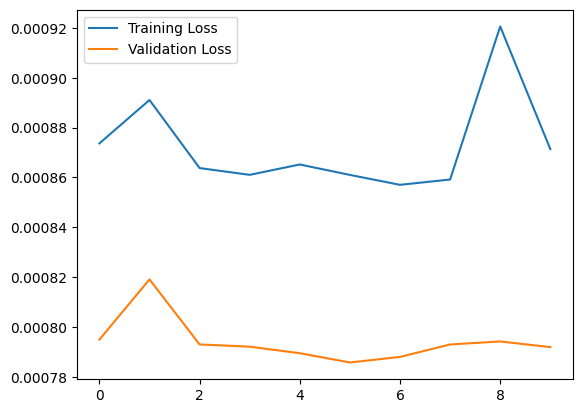

[0.0007919952040538192, 0.9999235272407532]


In [41]:
performance_plots(model, X_train, y_train, X_test, y_test)

Epoch 1/10
5107/5107 [==============================] - 17s 3ms/step - loss: 0.0110 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9999
Epoch 2/10
5107/5107 [==============================] - 15s 3ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 0.9999
Epoch 3/10
5107/5107 [==============================] - 15s 3ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 9.2306e-04 - val_accuracy: 0.9999
Epoch 4/10
5107/5107 [==============================] - 15s 3ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9999
Epoch 5/10
5107/5107 [==============================] - 15s 3ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 9.2461e-04 - val_accuracy: 0.9999
Epoch 6/10
5107/5107 [==============================] - 15s 3ms/step - loss: 9.9588e-04 - accuracy: 0.9999 - val_loss: 8.9519e-04 - val_accuracy: 0.9999
Epoch 7/10
5107/5107 [==============================] - 15s 3ms/step - loss: 9.4648e-04 - accuracy: 0.9999 - val_l

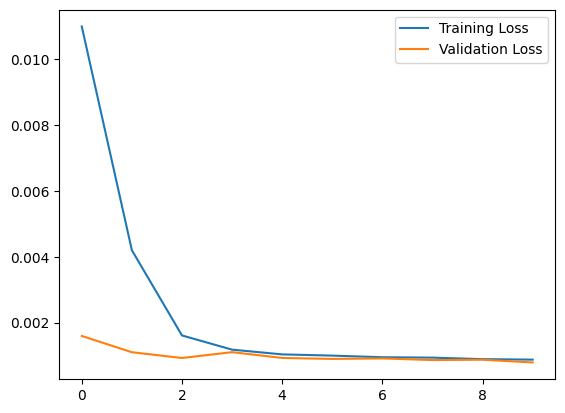

[0.0007869964465498924, 0.9999235272407532]


In [44]:
model_2 = Sequential([ #I will try a simpler model which I used on Lab 8
    Dense(64, input_dim = X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) #Changing the optimizer to see a difference

performance_plots(model_2,X_train,y_train,X_test,y_test)